In [1]:
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import pandas
import seaborn
seaborn.set_style("darkgrid")

# Project imports
from legacy_model import *

In [2]:
# Get raw data
raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")

In [16]:
# Reset output file timestamp per run
file_timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Reset seed per run
numpy.random.seed(0)

# Setup training time period
min_training_years = 25
term_range = range(raw_data["term"].min() + min_training_years,
                   raw_data["term"].max()+1)

baseline_window_range = range(2, 50)
for window in baseline_window_range:
    raw_data.loc[:, "baseline_{0}_predicted".format(window)] = numpy.nan

# Iterate over all terms
for term in term_range:
    print(term)
    
    # Outer loop constants and tests
    test_index = (raw_data.loc[:, "term"] == term).values
    if test_index.sum() == 0:
            continue

    # Iterate over window sizes
    for baseline_window in baseline_window_range:
        # Baseline training index
        baseline_train_index = ((raw_data.loc[:, "term"] < term) & (raw_data.loc[:, "term"] >= (term-baseline_window))).values
        
        # Fit the "baseline" model
        d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
        d.fit(numpy.zeros_like(raw_data.loc[baseline_train_index, :]), 
              (raw_data.loc[baseline_train_index, "justice_outcome_disposition"]).astype(int))

        # Store baseline predictions
        raw_data.loc[test_index, "baseline_{0}_predicted".format(baseline_window)] = d.predict(numpy.zeros_like(raw_data.loc[test_index, :]))

1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


### Justice Accuracy - Reverse/Not-Reverse

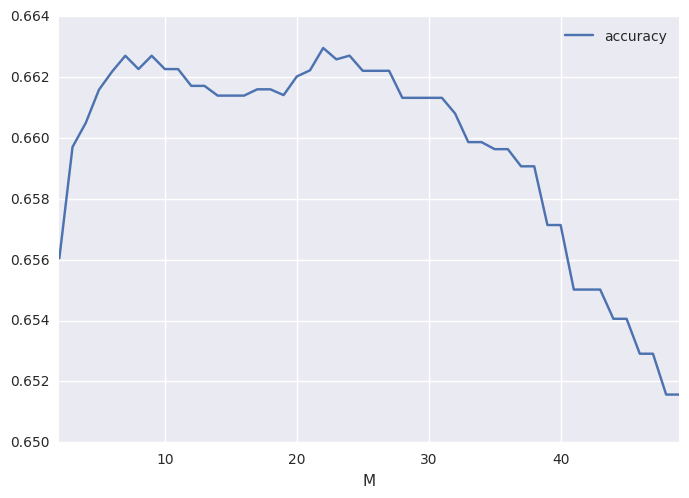

In [17]:
# Store data across all windows
justice_window_accuracy_data = []

# Iterate over all windows
for window in baseline_window_range:
    # Get index and outcomes
    evaluation_index = raw_data.loc[:, "term"].isin(term_range)
    reverse_target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"] > 0).astype(int)
    reverse_target_baseline = (raw_data.loc[evaluation_index, "baseline_{0}_predicted".format(window)] > 0).astype(int)
    
    # Append to dataset
    justice_window_accuracy_data.append((window, sklearn.metrics.accuracy_score(reverse_target_actual, reverse_target_baseline)))
    
# Create dataframe
justice_window_accuracy_df = pandas.DataFrame(justice_window_accuracy_data, columns=["M", "accuracy"])
justice_window_accuracy_df.set_index(justice_window_accuracy_df["M"], inplace=True)
del justice_window_accuracy_df["M"]
justice_window_accuracy_df.plot()

### Case Accuracy - Reverse/Not-Reverse

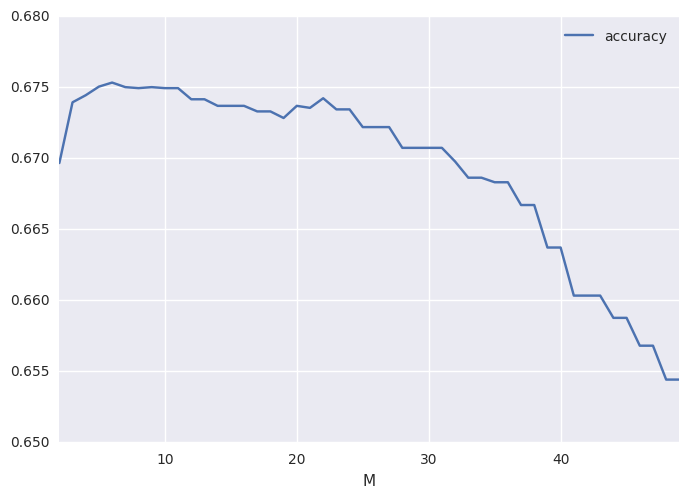

In [20]:
# Store data across all windows
case_window_accuracy_data = []

# Outer loop
raw_data.loc[:, "justice_outcome_disposition_reverse"] = (raw_data.loc[evaluation_index, "justice_outcome_disposition"] > 0).astype(int)
docket_actual_reverse = (raw_data.loc[evaluation_index, :].groupby("docketId")["case_outcome_disposition"].mean() > 0.5).astype(int)

    
# Iterate over all windows
for window in baseline_window_range:
    # Get index and outcomes
    raw_data.loc[:, "baseline_predicted_reverse"] = (raw_data.loc[evaluation_index, "baseline_{0}_predicted".format(window)] > 0).astype(int)
    docket_baseline_predicted_reverse = (raw_data.loc[evaluation_index, :].groupby("docketId")["baseline_predicted_reverse"].mean() > 0.5).astype(int)

    
    # Append to dataset
    case_window_accuracy_data.append((window, sklearn.metrics.accuracy_score(docket_actual_reverse, docket_baseline_predicted_reverse)))
    
# Create dataframe
case_window_accuracy_df = pandas.DataFrame(case_window_accuracy_data, columns=["M", "accuracy"])
case_window_accuracy_df.set_index(case_window_accuracy_df["M"], inplace=True)
del case_window_accuracy_df["M"]
case_window_accuracy_df.plot()

In [22]:
# Output model results
raw_data.to_csv("../data/output/raw_docket_justice_baseline_model_most_frequent_memory_experiment.csv.gz", compression="gzip")